### How to use PyTorch LSTMs for time series regression

##### 1. 라이브러리 불러오기

In [1]:
import os
import pandas as pd             #데이터를 Dataframe으로 다루는 라이브러리
from pandas import DataFrame
import numpy as np              #데이터를 행열 또는 array 형태로 다루는 라이브러리
import random

from time import time
from datetime import datetime
import math
from copy import deepcopy

import matplotlib.pyplot as plt #데이터를 그래프 plot으로 보여주는 라이브러리
import seaborn as sns

import requests                 #네트워크 접근 라이브러리
from bs4 import BeautifulSoup   #웹사이트 접근하는 라이브러리

from sklearn.preprocessing import StandardScaler

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
torch.manual_seed(77)

from torch import nn as nn
from torch import optim
from torch.nn import functional as F
from torch import tensor

import warnings
warnings.filterwarnings('ignore')

##### 2. KRX 종목으로 주가종목 데이터 가져오기

In [2]:
target = '삼성전자'

# 종목 이름을 입력하면 종목에 해당하는 코드를 불러와
# 네이버 금융(http://finance.naver.com)에 넣어줌

code_krx = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', encoding='cp949', header=0)[0]
# 종목코드가 6자리이기 때문에 6자리를 맞춰주기 위해 설정해줌
code_krx


,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,DSR제강,69730,1차 철강 제조업,"와이어로프,각종 경강선,철선제품,PC강선,아연도 강연선 제조",2003-01-28,12월,"홍하종, 홍석빈 (각자 대표이사)",http://www.dsrcorp.com,전라남도
1,GS글로벌,1250,상품 종합 도매업,"수출입업(시멘트,철강금속,전기전자,섬유,기계화학),상품중개,광업,채석업/하수처리 서...",1976-06-26,12월,이영환,http://www.gsgcorp.com,서울특별시
2,HDC랩스,39570,전기 및 통신 공사업,"기계설비공사, 스마트홈, 지능형 빌딩, SOC, 인테리어, 조경, 시설관리",2015-09-24,12월,김성은,http://www.hdc-labs.com/,서울특별시
3,HDC현대산업개발,294870,건물 건설업,"외주주택, 자체공사, 일반건축, 토목 등",2018-06-12,12월,"정경구, 조태제(각자 대표이사)",http://www.hdc-dvp.com,서울특별시
4,HD한국조선해양,9540,기타 금융업,"선박,해양구조물,엔진,펌프 전동기,중전기,중장비 제조/자동창고,물류시스템",1999-08-24,12월,"정기선, 김성준 (각자 대표이사)",http://www.ksoe.co.kr,경기도
...,...,...,...,...,...,...,...,...,...
2758,큐러블,86460,자연과학 및 공학 연구개발업,유전체 분석 서비스,2013-07-01,12월,김진찬,http://www.curablent.com,경기도
2759,타임기술,318660,소프트웨어 개발 및 공급업,"ILS(종합군수지원), IETM(전자식기술교범), CBT(전자식교보재), 기술번역",2021-06-24,12월,주양효,http://timett.co.kr,경상남도
2760,티엘엔지니어링,413300,"건축기술, 엔지니어링 및 관련 기술 서비스업",클린룸 설계 및 시공,2022-09-27,12월,서충옥,http://tleng.kr,경기도
2761,파마리서치바이오,217950,의약품 제조업,"메디컬 에스테틱, 생물학적 제재",2015-11-05,12월,"백승걸, 원치엽 (각자대표)",http://www.pr-bio.co.kr,강원특별자치도


In [3]:
code_krx.종목코드 = code_krx.종목코드.map('{:06d}'.format)
# 우리가 필요한 것은 회사명과 종목코드이기 때문에 필요없는 column들은 제외해준다.
code_krx = code_krx[['회사명', '종목코드']]
# code_krx
target_code = code_krx[code_krx['회사명']==target]
target_code

,회사명,종목코드
1808,삼성전자,005930


In [4]:
# 종목코드로 네이버에서 종목 주소 생성 확인
def get_url(code): #(item_name, code_df):
    url = 'https://finance.naver.com/item/sise_day.naver?code='+'{code}'.format(code=code).lstrip()
    return url
code = target_code['종목코드'].iloc[0]
url = get_url(code)
url

'https://finance.naver.com/item/sise_day.naver?code=005930'

In [5]:
# 위에서 찾은 네이버 타겟종목 페이지에서 마지막 페이지 크기 확인
url_page = url + '&page=1'
headers = {'User-agent':'Mozilla/5.0'}
html = requests.get(url_page, headers=headers).text
soup = BeautifulSoup(html,"html.parser")
tags = soup.find_all('a')
# print(tags[11]["href"])
last_page = tags[11]["href"]
last_page = last_page.split('=')[2]
last_page
# print(f"target_code :회사명 == [{target_code['회사명'].iloc[0]}] 종목코드 == [{target_code['종목코드'].iloc[0]}] 마지막 페이지 == [{last_page}]")

'725'

In [6]:
last_page = int(150) # 임시 150 페이지 까지만

# 일 데이터를 담을 df_code라는 DataFrame 정의
df_code = pd.DataFrame()
url.lstrip()
for page in range(1,int(last_page)+1):
    # pg_url = ('{url}&page={page}'.format(url=url, page=page)).lstrip()
    # pg = pd.read_html(pg_url,encoding='euc-kr',header=1)[0]
    # df_code = pd.concat([df_code,pg])
    req = requests.get(f'{url}&page={page}',headers=headers)
    df_code = pd.concat([df_code,pd.read_html(req.text,encoding='euc-kr')[0]],ignore_index=True)

# df.dropna()를 이용해 결측값 있는 행 제거
df_code = df_code.dropna()
df_code.reset_index(drop=True, inplace=True)

# 상위 15개 데이터 확인하기
df_code.head(15)


,날짜,종가,전일비,시가,고가,저가,거래량
0,2025.06.05,59100.0,"상승 1,300",58100.0,59900.0,57900.0,23260446.0
1,2025.06.04,57800.0,"상승 1,000",57200.0,57900.0,56800.0,19649983.0
2,2025.06.02,56800.0,상승 600,56300.0,57300.0,56200.0,12870515.0
3,2025.05.30,56200.0,상승 100,56200.0,57200.0,55800.0,26219683.0
4,2025.05.29,56100.0,상승 200,56200.0,56400.0,55600.0,12936810.0
5,2025.05.28,55900.0,"상승 2,000",54300.0,56100.0,54200.0,17516283.0
6,2025.05.27,53900.0,하락 800,54200.0,54500.0,53800.0,13439520.0
7,2025.05.26,54700.0,상승 500,53900.0,55000.0,53700.0,10901337.0
8,2025.05.23,54200.0,하락 500,55000.0,55200.0,54100.0,11247115.0
9,2025.05.22,54700.0,"하락 1,000",55300.0,55500.0,54500.0,15254278.0


##### data split

In [7]:
# 한글로 된 컬럼명을 영어로 바꿔줌
stock_data = df_code.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'})
stock_data['diff'] = stock_data['diff'].str.replace('상승','').str.replace('하락','').str.replace('보합','').str.replace(',','').str.replace(' ','').str.strip()
# 데이터의 타입을 int형으로 바꿔줌
stock_data[['close', 'diff', 'open', 'high', 'low', 'volume']] = stock_data[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(float)
# 컬럼명 'date'의 타입을 date로 바꿔줌
stock_data['date'] = pd.to_datetime(stock_data['date'])
# 일자(date)를 기준으로  정렬
stock_data = stock_data.sort_values(by=['date'],ascending = True)
# 상위 5개 데이터 확인
print(stock_data.shape)
stock_data.reset_index(drop=True, inplace=True)
stock_data.head(15)

(1500, 7)


,date,close,diff,open,high,low,volume
0,2019-04-29,46150.0,1300.0,45150.0,46150.0,45100.0,8777517.0
1,2019-04-30,45850.0,300.0,46000.0,46300.0,45350.0,11121273.0
2,2019-05-02,45900.0,50.0,45500.0,46150.0,45400.0,8625126.0
3,2019-05-03,45300.0,600.0,45900.0,46050.0,45300.0,6562916.0
4,2019-05-07,44850.0,450.0,45250.0,45300.0,44400.0,12014907.0
5,2019-05-08,44250.0,600.0,44300.0,44850.0,44200.0,10398754.0
6,2019-05-09,42450.0,1800.0,43900.0,44250.0,42450.0,23029718.0
7,2019-05-10,42900.0,450.0,42600.0,43450.0,42450.0,14579512.0
8,2019-05-13,42650.0,250.0,42500.0,43200.0,42350.0,7635079.0
9,2019-05-14,42650.0,0.0,41300.0,43100.0,41300.0,11563730.0


In [8]:
df = stock_data.copy()
df = df.set_index('date')
df

,close,diff,open,high,low,volume
date,,,,,,
2019-04-29,46150.0,1300.0,45150.0,46150.0,45100.0,8777517.0
2019-04-30,45850.0,300.0,46000.0,46300.0,45350.0,11121273.0
2019-05-02,45900.0,50.0,45500.0,46150.0,45400.0,8625126.0
2019-05-03,45300.0,600.0,45900.0,46050.0,45300.0,6562916.0
2019-05-07,44850.0,450.0,45250.0,45300.0,44400.0,12014907.0
...,...,...,...,...,...,...
2025-05-29,56100.0,200.0,56200.0,56400.0,55600.0,12936810.0
2025-05-30,56200.0,100.0,56200.0,57200.0,55800.0,26219683.0
2025-06-02,56800.0,600.0,56300.0,57300.0,56200.0,12870515.0


array([<Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>,
       <Axes: xlabel='date'>, <Axes: xlabel='date'>], dtype=object)

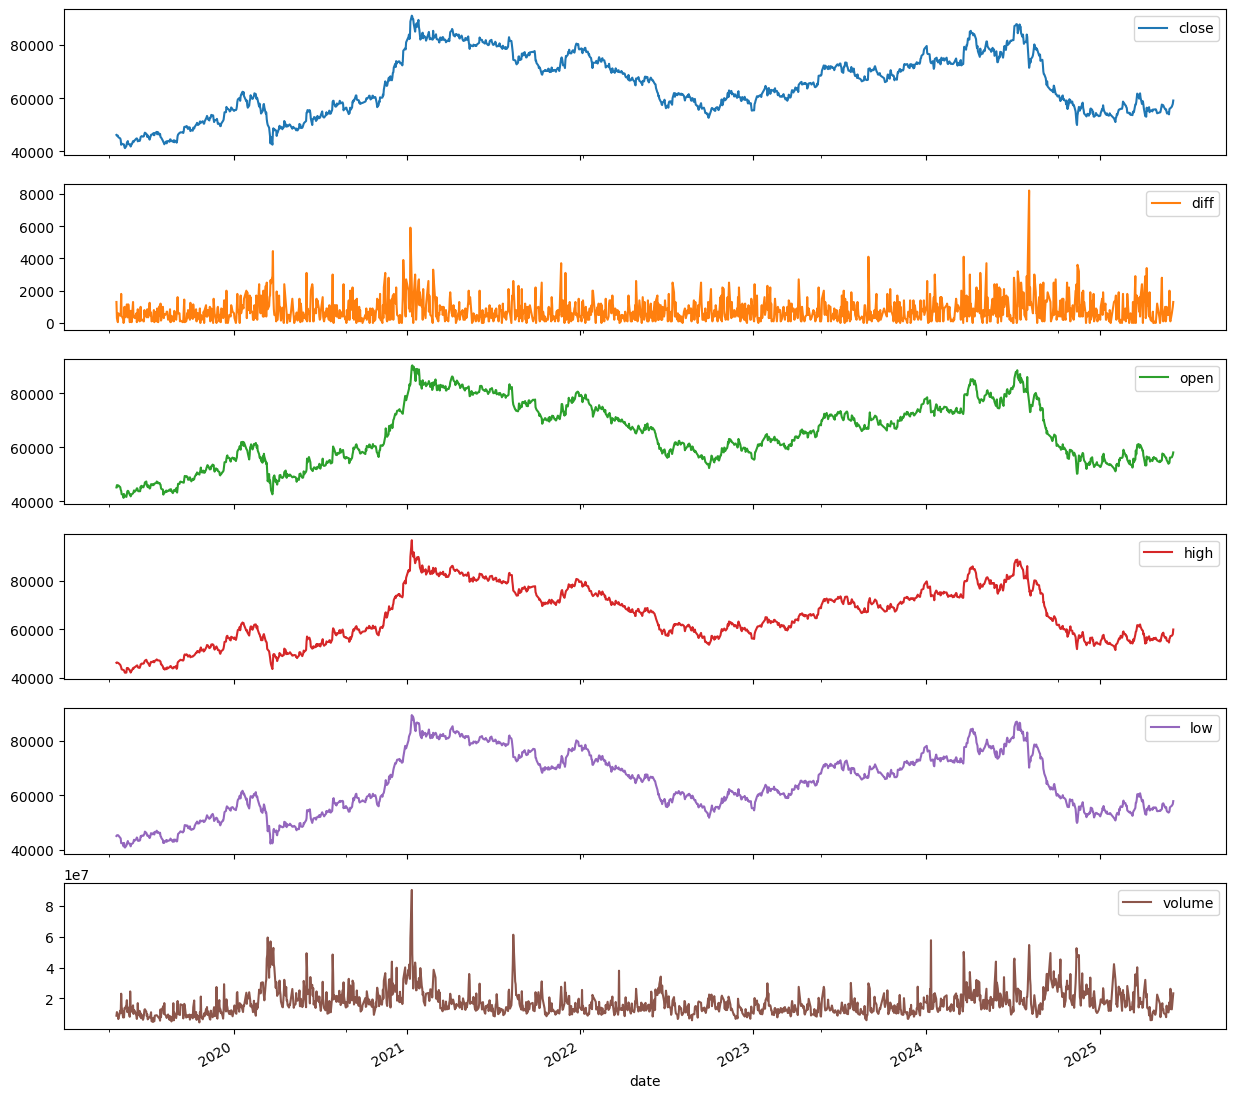

In [9]:

df.plot(subplots=True, figsize=(15,15))

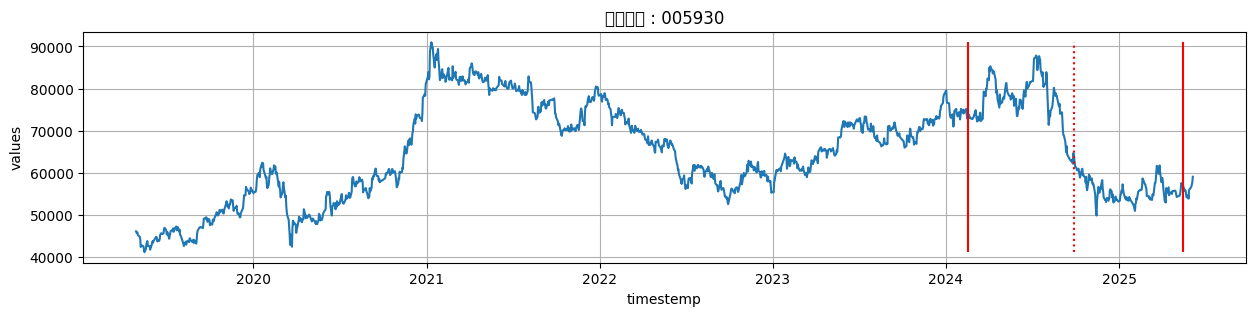

In [10]:
fig, ax = plt.subplots(1,1, figsize=(15,3))
ax.plot(df['close'])
ax.vlines(df[df.index == df.iloc[round(len(df)*0.79)].name].index,
          ymax=(max(df['close'])+2), 
          ymin=(min(df['close'])-1), colors='red', linestyles= '-')
ax.vlines(df[df.index == df.iloc[round(len(df)*0.89)].name].index,
          ymax=(max(df['close'])+2), 
          ymin=(min(df['close'])-1), colors='red', linestyles= ':')
ax.vlines(df[df.index == df.iloc[round(len(df)*0.99)].name].index,
          ymax=(max(df['close'])+2), 
          ymin=(min(df['close'])-1), colors='red', linestyles= '-')
ax.set_title(target + ' : ' + code)
ax.set_xlabel('timestemp')
ax.set_ylabel('values')
ax.grid()
fig.tight_layout
plt.show()

In [11]:
# 데이터를 훈련, 검증, 테스트로 나눈다.
df_train = df.iloc[:round(len(df)*0.8)]
df_valid = df.iloc[round(len(df)*0.8):round(len(df)*0.9)]
df_test = df.iloc[round(len(df)*0.9):len(df)]

print(f" df.shape 0.8 : {round(df.shape[0]*0.8)}")
print(f" df_train.shape : {df_train.shape}")
print(f" df_valid.shape : {df_valid.shape}")
print(f" df_test.shape : {df_test.shape}")
# print(f" check {(round(df.shape[0]*0.7)) == df_train.shape[0]+df_valid.shape[0]+df_test.shape[0]}")

 df.shape 0.8 : 1200
 df_train.shape : (1200, 6)
 df_valid.shape : (150, 6)
 df_test.shape : (150, 6)


In [12]:
df_train

,close,diff,open,high,low,volume
date,,,,,,
2019-04-29,46150.0,1300.0,45150.0,46150.0,45100.0,8777517.0
2019-04-30,45850.0,300.0,46000.0,46300.0,45350.0,11121273.0
2019-05-02,45900.0,50.0,45500.0,46150.0,45400.0,8625126.0
2019-05-03,45300.0,600.0,45900.0,46050.0,45300.0,6562916.0
2019-05-07,44850.0,450.0,45250.0,45300.0,44400.0,12014907.0
...,...,...,...,...,...,...
2024-03-04,74900.0,1500.0,74300.0,75000.0,74000.0,23210474.0
2024-03-05,73700.0,1200.0,74600.0,74800.0,73700.0,19505125.0
2024-03-06,72900.0,800.0,73200.0,73500.0,72700.0,21547905.0


In [13]:
scaler = StandardScaler()
scaler.fit(df_train)
df_train_scaled = pd.DataFrame(scaler.transform(df_train),columns=df.columns)
df_valid_scaled = pd.DataFrame(scaler.transform(df_valid),columns=df.columns)
df_test_scaled = pd.DataFrame(scaler.transform(df_test),columns=df.columns)

In [14]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5, predict_length=1):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.predict_length = predict_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()
        self.datetime = dataframe.index 

    def __len__(self):
        return len(self.X) - (self.sequence_length + self.predict_length)
    
    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.sequence_length
        seq_x = self.X[s_begin:s_end]
        r_begin = s_end #- self.predict_length
        r_end = r_begin + self.predict_length
        seq_y = self.y[r_begin :r_end]
        return seq_x, seq_y

 # start point padding type
    # def __len__(self):
    #     return self.X.shape[0]

    # def __getitem__(self, i): 
    #     if i >= self.sequence_length - 1:
    #         i_start = i - self.sequence_length + 1
    #         x = self.X[i_start:(i + 1), :]
    #     else:
    #         padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
    #         x = self.X[0:(i + 1), :]
    #         x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [15]:
target='close'
features= df.columns
sequence_length = 13
predict_length = 1

train_dataset = SequenceDataset(
    df_train_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)

i = 27
X, y = train_dataset[i]
print(X)
print(y)

tensor([[-1.7212, -0.1971, -1.7644, -1.7570, -1.7448, -0.9433],
        [-1.7168, -1.0480, -1.7208, -1.7440, -1.7010, -1.2097],
        [-1.7387, -0.7386, -1.7208, -1.7397, -1.7229, -0.9664],
        [-1.8129,  0.1897, -1.7731, -1.7960, -1.8017,  0.0732],
        [-1.7911, -0.7386, -1.8123, -1.8177, -1.8105, -0.8768],
        [-1.7998, -0.9707, -1.8123, -1.8264, -1.8017, -0.5551],
        [-1.7605, -0.4292, -1.8123, -1.7874, -1.7798, -1.0431],
        [-1.6732,  0.4218, -1.6642, -1.7050, -1.6615, -0.7396],
        [-1.6601, -0.8933, -1.7165, -1.7006, -1.6747, -1.1492],
        [-1.6426, -0.8159, -1.6381, -1.6746, -1.6440, -0.8602],
        [-1.6601, -0.8159, -1.6860, -1.6746, -1.6440, -1.2824],
        [-1.6513, -0.9707, -1.6860, -1.6746, -1.6440, -1.1581],
        [-1.6426, -0.9707, -1.6337, -1.6573, -1.6089, -0.8889]])
tensor([-1.5727])


In [16]:
X, y = train_dataset[i+1]
print(X)
print(y)

tensor([[-1.7168, -1.0480, -1.7208, -1.7440, -1.7010, -1.2097],
        [-1.7387, -0.7386, -1.7208, -1.7397, -1.7229, -0.9664],
        [-1.8129,  0.1897, -1.7731, -1.7960, -1.8017,  0.0732],
        [-1.7911, -0.7386, -1.8123, -1.8177, -1.8105, -0.8768],
        [-1.7998, -0.9707, -1.8123, -1.8264, -1.8017, -0.5551],
        [-1.7605, -0.4292, -1.8123, -1.7874, -1.7798, -1.0431],
        [-1.6732,  0.4218, -1.6642, -1.7050, -1.6615, -0.7396],
        [-1.6601, -0.8933, -1.7165, -1.7006, -1.6747, -1.1492],
        [-1.6426, -0.8159, -1.6381, -1.6746, -1.6440, -0.8602],
        [-1.6601, -0.8159, -1.6860, -1.6746, -1.6440, -1.2824],
        [-1.6513, -0.9707, -1.6860, -1.6746, -1.6440, -1.1581],
        [-1.6426, -0.9707, -1.6337, -1.6573, -1.6089, -0.8889],
        [-1.5727,  0.1124, -1.6163, -1.6052, -1.5958, -0.4658]])
tensor([-1.5291])


In [17]:
print(df_train[features].iloc[i: (i + sequence_length)])

              close    diff     open     high      low      volume
date                                                              
2019-06-10  44800.0   600.0  44300.0  44850.0  44050.0   8792182.0
2019-06-11  44850.0    50.0  44800.0  45000.0  44550.0   6664872.0
2019-06-12  44600.0   250.0  44800.0  45050.0  44300.0   8607439.0
2019-06-13  43750.0   850.0  44200.0  44400.0  43400.0  16906541.0
2019-06-14  44000.0   250.0  43750.0  44150.0  43300.0   9322873.0
2019-06-17  43900.0   100.0  43750.0  44050.0  43400.0  11890424.0
2019-06-18  44350.0   450.0  43750.0  44500.0  43650.0   7994928.0
2019-06-19  45350.0  1000.0  45450.0  45450.0  45000.0  10417690.0
2019-06-20  45500.0   150.0  44850.0  45500.0  44850.0   7147785.0
2019-06-21  45700.0   200.0  45750.0  45800.0  45200.0   9454913.0
2019-06-24  45500.0   200.0  45200.0  45800.0  45200.0   6085066.0
2019-06-25  45600.0   100.0  45200.0  45800.0  45200.0   7076774.0
2019-06-26  45700.0   100.0  45800.0  46000.0  45600.0   92260

In [18]:
def my_collate_fn(batch):
    data = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    # batch_first=True로 설정
    padded_batch = pad_sequence(batch, batch_first=True, padding_value=0) # padding_value는 선택 
    labels_tensor = torch.tensor(labels, dtype=torch.long)
    return padded_batch #, labels_tensor

In [19]:
target = 'close'
features = df_train_scaled.columns
batch_size = 30
sequence_length = 12
predict_length = 1

train_dataset = SequenceDataset(
    df_train_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)
valid_dataset = SequenceDataset(
    df_valid_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)
test_dataset = SequenceDataset(
    df_test_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)#, collate_fn=my_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)#, collate_fn=my_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)#,collate_fn=my_collate_fn)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([30, 12, 6])
Target shape: torch.Size([30, 1])


In [20]:
# df_train.describe()
mean = df_train.mean()
var = df_train.var()

### LSTM Model

In [21]:
class LSTM_Layer(nn.Module):
    def __init__(self, 
                 num_features, 
                 hidden_units,
                 predict_length, 
                 bias=True, 
                 num_layers=3, 
                 drop_ratio=0.0,
                 bi_dir=False,
                 device='cpu'):
        super().__init__()
        self.num_features = num_features  # feature's = 현재 1
        self.hidden_units = hidden_units
        self.bias = bias
        self.num_layers = num_layers
        self.drop_ratio = drop_ratio
        self.bi_dir = bi_dir
        self.device = device

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            bias=bias,
            batch_first=True,
            num_layers=self.num_layers,
            dropout=drop_ratio,
            bidirectional=bi_dir
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=predict_length, bias=bias)

        # self.sig = nn.Sigmoid()
        # self.Tanh = nn.Tanh()

    def forward(self, x):
        # print(f"x.shape-ori: {x.shape}")
        # x = x.unsqueeze(2)
        # print(f"x.shape-unsqz : {x.shape}")
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(self.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(self.device)
        hh, (hn, _) = self.lstm(x, (h0, c0))
        # print(f"hh.shape {h0.shape}")
        # raise
        out = self.linear(hh[:,-1,:])
        # out = self.linear(h0[2])

        return out

In [22]:
len(features)

6

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"is_available device : {device}")

learning_rate = 0.001
num_hidden_units = 124
epochs = 100

model = LSTM_Layer(num_features=len(features), hidden_units=num_hidden_units, predict_length=predict_length, device=device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


is_available device : cuda


In [24]:
def train_model(data_loader, model, loss_function, optimizer, device):
    num_batches = len(data_loader)
    total_loss = 0
    model.to(device)
    
    model.train()
    for i, (X, y) in enumerate(data_loader):
        X = X.to(device)
        y = y.to(device)
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def eval_model(data_loader, model, loss_function, device=device):
    num_batches = len(data_loader)
    total_loss = 0
    
    model.to(device)

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            # print(f"input x : {X.shape}")
            # print(f"label y : {y.shape}")
            # print(f"output : {output.shape}")
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"eval loss: {avg_loss}")
    return avg_loss


def infer_model(data_loader, model, device=device):
    num_batches = len(data_loader)
    total_loss = 0
    predict = []
    label = []
    model.to(device)

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X)
            # print(output.shape)
            # raise
            pred = output.to('cpu').numpy()
            np.squeeze(pred)
            predict.append(list(pred[0]))
            true = y.to('cpu').numpy()
            np.squeeze(true)
            label.append(list(true[0]))
        
    return predict, label


def forecasting (data, model, device=device):
    model.to(device)
    model.eval()
    with torch.no_grad():
            X = torch.from_numpy(data).to(torch.float32).to(device)
            X = X.unsqueeze(0)
            output = model(X)
            forecast = output.to('cpu').numpy()
            forecast = np.squeeze(forecast[0])
        
    return forecast


In [25]:
print("Untrained evaluate\n--------")
eval_model(valid_loader, model, loss_function, device=device)
print()

epoch = []
train_loss_list = []
eval_loss_list = []

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer, device=device)
    eval_loss = eval_model(valid_loader, model, loss_function, device=device)
    print()
    epoch.append(ix_epoch+1)
    train_loss_list.append(train_loss)
    eval_loss_list.append(eval_loss)
result = pd.DataFrame({'epoch':epoch, 'train_loss':train_loss_list, 'eval':eval_loss_list})
result


Untrained evaluate
--------
eval loss: 1.6782868206501007

Epoch 0
---------
Train loss: 0.27123249847537434
eval loss: 0.13007394690066576

Epoch 1
---------
Train loss: 0.03658753697975324
eval loss: 0.09423108445480466

Epoch 2
---------
Train loss: 0.027602775261188164
eval loss: 0.08037645183503628

Epoch 3
---------
Train loss: 0.026389514693082906
eval loss: 0.07823325833305717

Epoch 4
---------
Train loss: 0.021920156318885393
eval loss: 0.06870497670024633

Epoch 5
---------
Train loss: 0.01949159034456198
eval loss: 0.06115784449502826

Epoch 6
---------
Train loss: 0.01675601377605628
eval loss: 0.05870362604036927

Epoch 7
---------
Train loss: 0.016123905897331543
eval loss: 0.05510514369234443

Epoch 8
---------
Train loss: 0.014193735527208982
eval loss: 0.06032149260863662

Epoch 9
---------
Train loss: 0.01530928155168509
eval loss: 0.04373431531712413

Epoch 10
---------
Train loss: 0.012377589117162503
eval loss: 0.04549043998122215

Epoch 11
---------
Train loss: 0

,epoch,train_loss,eval
0,1,0.271232,0.130074
1,2,0.036588,0.094231
2,3,0.027603,0.080376
3,4,0.026390,0.078233
4,5,0.021920,0.068705
...,...,...,...
95,96,0.006720,0.034181
96,97,0.006562,0.033351
97,98,0.006730,0.036247
98,99,0.006515,0.031415


In [26]:
PATH = "/home/augustine77/mylab/sim/sim/02_DLnote/results/LSTM_samsumg.pth"
torch.save(model.state_dict(), PATH)

In [27]:
model2 = LSTM_Layer(num_features=len(features), hidden_units=num_hidden_units, predict_length=predict_length, device=device)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate)

In [28]:
model2.load_state_dict(torch.load(PATH))

<All keys matched successfully>

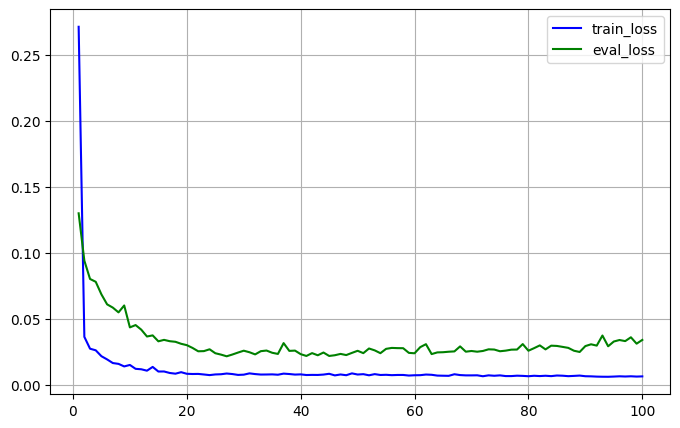

In [29]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
ax.plot(result['epoch'],result['train_loss'], color='blue', label='train_loss')
ax.plot(result['epoch'],result['eval'], color='green', label='eval_loss')
ax.legend()
ax.grid()
plt.show()

In [30]:
predict, trues = infer_model(test_loader, model=model, device=device)


In [31]:
predict = np.array(predict).squeeze()
trues = np.array(trues).squeeze()
infer_result = pd.DataFrame({'predict': predict, 'trues': trues}, index=test_dataset.datetime[13:])



In [32]:
infer_result.index = df_test.index[13:]
infer_result

,predict,trues
date,,
2024-11-11,-0.586577,-0.655698
2024-11-12,-0.629064,-0.830373
2024-11-13,-0.820508,-1.005047
2024-11-14,-1.025850,-1.214656
2024-11-15,-1.190011,-1.275792
...,...,...
2025-05-29,-0.907279,-0.751769
2025-05-30,-0.715508,-0.734302
2025-06-02,-0.710287,-0.725568


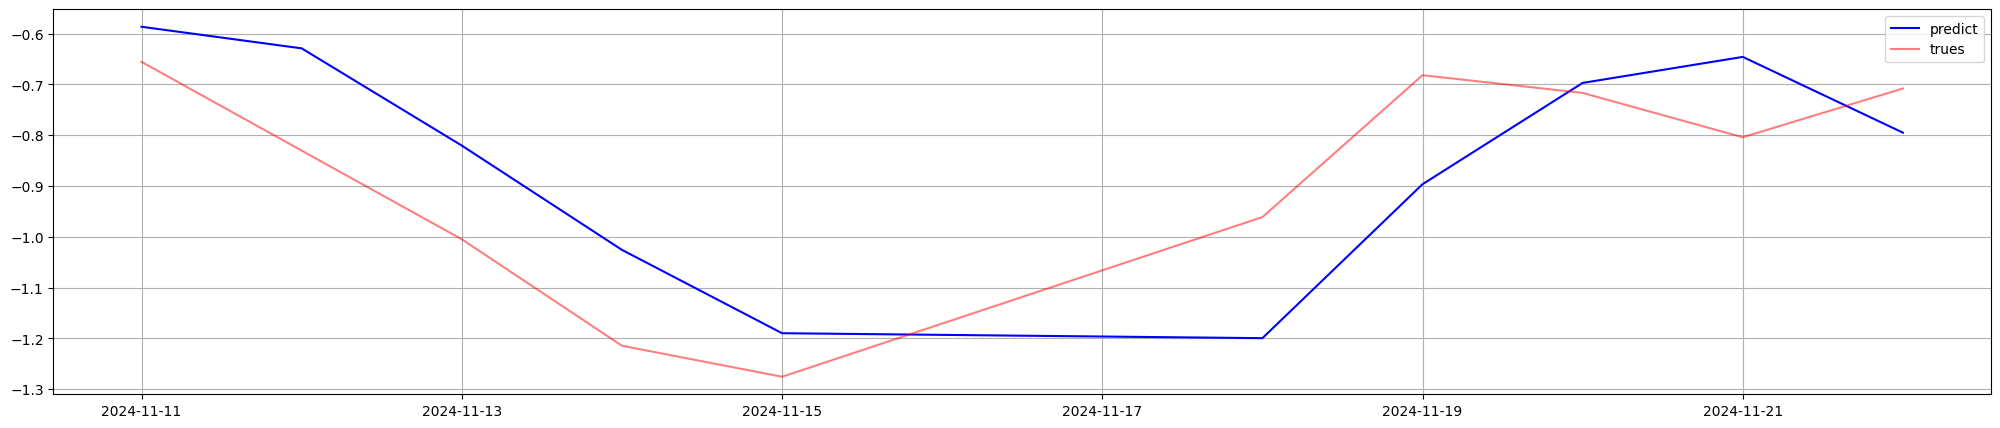

In [33]:
fig, ax = plt.subplots(1,1,figsize=(25,5))
ax.plot(infer_result['predict'].iloc[:10], color='blue', label='predict')
ax.plot(infer_result['trues'].iloc[:10], color='red', ls='-', alpha = 0.5, label='trues')
ax.legend()
ax.grid()
plt.show()

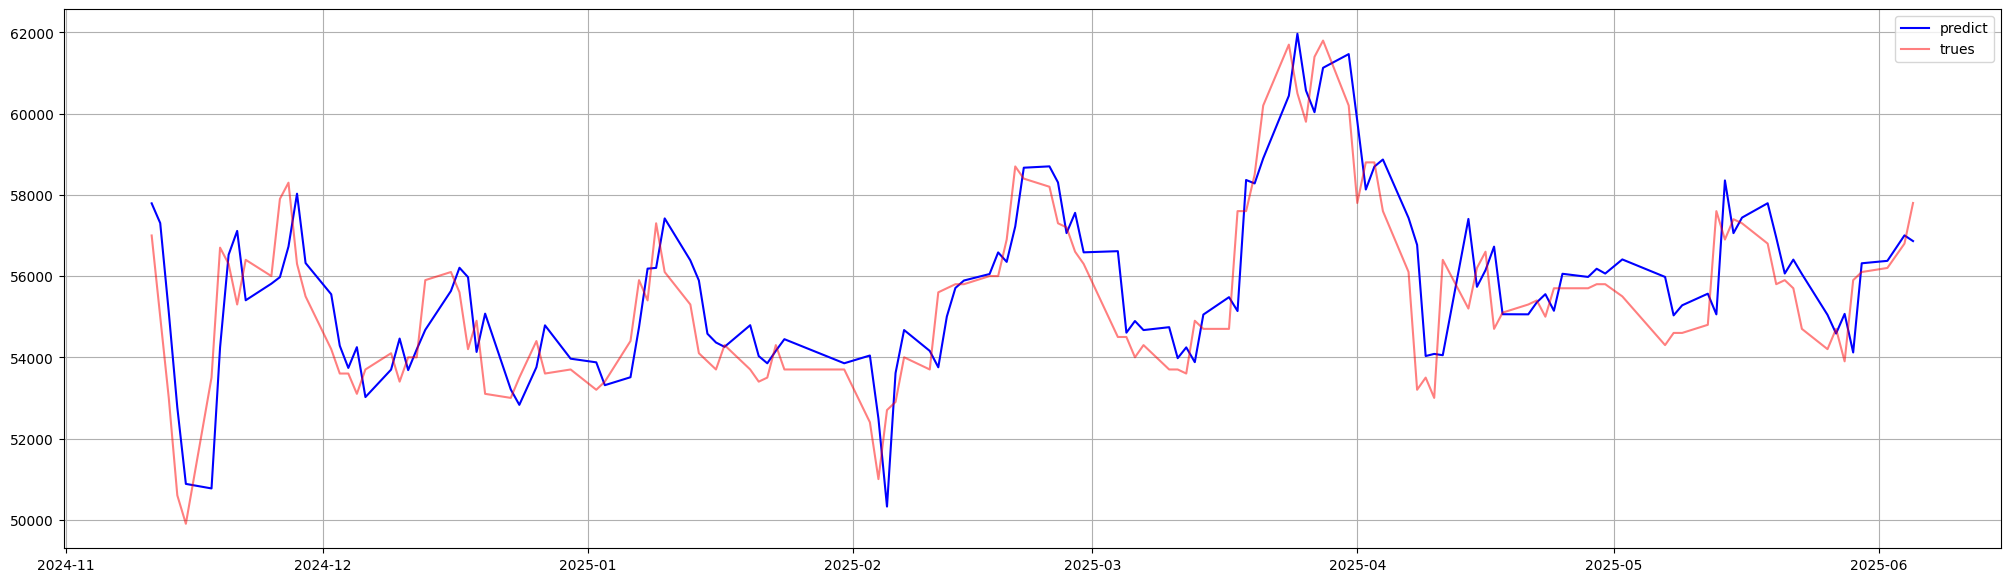

In [34]:
mean = scaler.mean_
var = scaler.var_

df_test_pred_descaled = (infer_result['predict'] * np.sqrt(var[0])) + mean[0]
df_test_gt_descaled = (infer_result['trues'] * np.sqrt(var[0])) + mean[0]

fig, ax = plt.subplots(1,1,figsize=(25,7))
ax.plot(df_test_pred_descaled, color='blue', label='predict')
ax.plot(df_test_gt_descaled, color='red', ls='-', alpha = 0.5, label='trues')
ax.legend()
ax.grid()
plt.show()

In [35]:
pred_input = df_test.iloc[138:150,:]
pred_input = scaler.transform(pred_input)
pred_input.shape

(12, 6)

In [36]:
forecast = forecasting(pred_input, model=model, device=device)

In [37]:
forecast * np.sqrt(scaler.var_[0]) + scaler.mean_[0]

59585.62337175629


## [Seq 2 Seq : stock price](https://www.kaggle.com/code/arezalo/lstm-stock-price-predition-by-pytorch)

<img src="https://miro.medium.com/v2/resize:fit:1400/1*bDANsXS4eqiLBX_iS1NHjQ.jpeg">

In [38]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, inputs):
        context_vector = self.encoder(inputs)
        outputs = self.decoder(context_vector)
        return outputs

<img src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*UTlM-lb4156iwVBqgupLlw.jpeg">

<img src="https://miro.medium.com/v2/resize:fit:786/format:webp/1*fYw_890Nw7lCHNV8mFep9g.jpeg">

In [39]:
target = 'close'
features = df_train_scaled.columns
batch_size = 30
sequence_length = 25
predict_length = 7

train_dataset = SequenceDataset(
    df_train_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)
valid_dataset = SequenceDataset(
    df_valid_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)
test_dataset = SequenceDataset(
    df_test_scaled,
    target=target,
    features=features,
    sequence_length=sequence_length,
    predict_length = predict_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)#, collate_fn=my_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)#, collate_fn=my_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)#,collate_fn=my_collate_fn)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([30, 25, 6])
Target shape: torch.Size([30, 7])


In [40]:
i = 27
X, y = train_dataset[i]
print(X)
print(y)

tensor([[-1.7212, -0.1971, -1.7644, -1.7570, -1.7448, -0.9433],
        [-1.7168, -1.0480, -1.7208, -1.7440, -1.7010, -1.2097],
        [-1.7387, -0.7386, -1.7208, -1.7397, -1.7229, -0.9664],
        [-1.8129,  0.1897, -1.7731, -1.7960, -1.8017,  0.0732],
        [-1.7911, -0.7386, -1.8123, -1.8177, -1.8105, -0.8768],
        [-1.7998, -0.9707, -1.8123, -1.8264, -1.8017, -0.5551],
        [-1.7605, -0.4292, -1.8123, -1.7874, -1.7798, -1.0431],
        [-1.6732,  0.4218, -1.6642, -1.7050, -1.6615, -0.7396],
        [-1.6601, -0.8933, -1.7165, -1.7006, -1.6747, -1.1492],
        [-1.6426, -0.8159, -1.6381, -1.6746, -1.6440, -0.8602],
        [-1.6601, -0.8159, -1.6860, -1.6746, -1.6440, -1.2824],
        [-1.6513, -0.9707, -1.6860, -1.6746, -1.6440, -1.1581],
        [-1.6426, -0.9707, -1.6337, -1.6573, -1.6089, -0.8889],
        [-1.5727,  0.1124, -1.6163, -1.6052, -1.5958, -0.4658],
        [-1.5291, -0.3518, -1.5292, -1.5705, -1.5125, -0.4225],
        [-1.5640, -0.5065, -1.4987, -1.5

In [41]:
i = 27
X, y = train_dataset[i]
print(X)
print(y)

tensor([[-1.7212, -0.1971, -1.7644, -1.7570, -1.7448, -0.9433],
        [-1.7168, -1.0480, -1.7208, -1.7440, -1.7010, -1.2097],
        [-1.7387, -0.7386, -1.7208, -1.7397, -1.7229, -0.9664],
        [-1.8129,  0.1897, -1.7731, -1.7960, -1.8017,  0.0732],
        [-1.7911, -0.7386, -1.8123, -1.8177, -1.8105, -0.8768],
        [-1.7998, -0.9707, -1.8123, -1.8264, -1.8017, -0.5551],
        [-1.7605, -0.4292, -1.8123, -1.7874, -1.7798, -1.0431],
        [-1.6732,  0.4218, -1.6642, -1.7050, -1.6615, -0.7396],
        [-1.6601, -0.8933, -1.7165, -1.7006, -1.6747, -1.1492],
        [-1.6426, -0.8159, -1.6381, -1.6746, -1.6440, -0.8602],
        [-1.6601, -0.8159, -1.6860, -1.6746, -1.6440, -1.2824],
        [-1.6513, -0.9707, -1.6860, -1.6746, -1.6440, -1.1581],
        [-1.6426, -0.9707, -1.6337, -1.6573, -1.6089, -0.8889],
        [-1.5727,  0.1124, -1.6163, -1.6052, -1.5958, -0.4658],
        [-1.5291, -0.3518, -1.5292, -1.5705, -1.5125, -0.4225],
        [-1.5640, -0.5065, -1.4987, -1.5

In [42]:
class Encoder(nn.Module):
    def __init__(self, 
                 num_features, 
                 hidden_units,
                 predict_length, 
                 bias=True, 
                 num_layers=3, 
                 drop_ratio=0.0,
                 bi_dir=False,
                 device='cpu'):
        super().__init__()
        self.num_features = num_features  # feature's = 현재 1
        self.hidden_units = hidden_units
        self.bias = bias
        self.num_layers = num_layers
        self.drop_ratio = drop_ratio
        self.bi_dir = bi_dir
        self.device = device

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            bias=bias,
            batch_first=True,
            num_layers=self.num_layers,
            dropout=drop_ratio,
            bidirectional=bi_dir
        )

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(self.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_().to(self.device)
        out, (hidden_state, cell_state) = self.lstm(x, (h0, c0))

        return out, (hidden_state, cell_state)

In [43]:
class Decoder(nn.Module):
    def __init__(self, 
                 num_features, 
                 hidden_units,
                 predict_length, 
                 bias=True, 
                 num_layers=3, 
                 drop_ratio=0.0,
                 bi_dir=False,
                 device='cpu'):
        super().__init__()
        self.num_features = num_features  # feature's = 현재 1
        self.hidden_units = hidden_units
        self.bias = bias
        self.num_layers = num_layers
        self.drop_ratio = drop_ratio
        self.bi_dir = bi_dir
        self.device = device

        self.lstm = nn.LSTM(
            input_size=num_features,
            hidden_size=hidden_units,
            bias=bias,
            batch_first=True,
            num_layers=self.num_layers,
            dropout=drop_ratio,
            bidirectional=bi_dir
        )
        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1, bias=bias)

    def forward(self, initial_input, encoder_outputs, hidden, targets, 
                teacher_force_probability):
        
        decoder_sequence_length = targets.shape[1]
        outputs = torch.full_like(targets, 0).to(self.device)
        
        for t in range(decoder_sequence_length):            
            input_at_t = initial_input.unsqueeze(1)
            output, hidden = self.lstm(input_at_t, hidden)

            # outputs[:,t] = self.linear(output)
            outputs[:,t]  = self.linear(output).squeeze()
            # outputs[:,t] = out
            # print(f"out.shape : {out.shape}")
            # print(f"outputs[:,t].shape : {outputs[:,t].shape}")

            # Set-up input for next timestep
            teacher_force = random.random() < teacher_force_probability
            # The next timestep's input will either be this timestep's 
            # target or output
            input_at_t = targets[:,t] if teacher_force else outputs[:,t]

        return outputs

    # def forecast(self, initial_input, encoder_outputs, hidden, predict_length):
    #     outputs = torch.zeros_like((predict_length)).to(self.device)
    #     input_at_t = initial_input
    #     for t in range(predict_length):            
    #         output, hidden = self.lstm(input_at_t, hidden)
    #         outputs[t] = self.linear(output)
    #         input_at_t = outputs[t]
    #     return outputs

In [44]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, encoder_inputs, targets, teacher_force_probability):
        encoder_outputs, hidden = self.encoder(encoder_inputs)
        
        outputs = self.decoder(encoder_inputs[:,-1,:], encoder_outputs,
                               hidden, targets, teacher_force_probability)
        return outputs

    # def forecast(self, encoder_inputs, predict_length):
    #     encoder_outputs, hidden = self.encoder(encoder_inputs)
    #     outputs = self.decoder.forecast(encoder_inputs[-1], encoder_outputs,
    #                            hidden, predict_length)
        # return outputs

In [45]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f" 🤗 is_available device : \n\t{device}")

epochs = 30

learning_rate = 0.03
num_hidden_units = 124
hidden_size = 256
teacher_force_probability = 0.5

seq2seq = Seq2Seq(
                    Encoder(
                            num_features = len(features), 
                            hidden_units = num_hidden_units,
                            predict_length = predict_length, 
                            bias=True, 
                            num_layers=3, 
                            drop_ratio=0.0,
                            bi_dir=False,
                            device=device), 
                    Decoder(
                            num_features = len(features), 
                            hidden_units = num_hidden_units,
                            predict_length = predict_length, 
                            bias=True, 
                            num_layers=3, 
                            drop_ratio=0.0,
                            bi_dir=False,
                            device=device),
                )

loss_function = nn.MSELoss()
# loss_function = nn.L1Loss()

optimizer = torch.optim.Adam(seq2seq.parameters(), lr=learning_rate)

print(f"\n 🤩 loss_function : \n\t{loss_function}\n")
print(f" 🤓 optimizer : \n\t{optimizer}")

 🤗 is_available device : 
	cuda

 🤩 loss_function : 
	MSELoss()

 🤓 optimizer : 
	Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.03
    maximize: False
    weight_decay: 0
)


In [46]:
def train_model(data_loader, model, loss_function, optimizer, device, teacher_force_probability):
    num_batches = len(data_loader)
    total_loss = 0
    model.to(device)
    
    model.train()
    for i, (X, y) in enumerate(data_loader):
        X = X.to(device)
        y = y.to(device)
        output = model(X,y,teacher_force_probability)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def eval_model(data_loader, model, loss_function, device):
    num_batches = len(data_loader)
    total_loss = 0
    
    model.to(device)

    teacher_force_probability = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X, y, teacher_force_probability)

            # print(f"output.type -  output.shape: {type(output)} - {output.shape}")
            # print(f"y.shape -  y.type : {type(y)} - {y.shape}")
            # print(f"one out : {output[0,:]}")
            # print(f"loss_function(output, y) : {loss_function(output, y)}")
            # raise

            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"eval loss: {avg_loss}")
    return avg_loss


def infer_model(data_loader, model, device):
    num_batches = len(data_loader)
    total_loss = 0
    predict = []
    label = []
    model.to(device)

    teacher_force_probability = 0.0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            X = X.to(device)
            y = y.to(device)
            output = model(X, y, teacher_force_probability)
            # print(output.shape)
            # raise
            pred = output.to('cpu').numpy()
            np.squeeze(pred)
            predict.append(list(pred[0]))
            true = y.to('cpu').numpy()
            np.squeeze(true)
            label.append(list(true[0]))
        
    return predict, label


# def forecasting (data, model, device, predict_length):
#     model.to(device)
#     model.eval()
#     with torch.no_grad():
#             X = torch.from_numpy(data).to(torch.float32).to(device)
#             X = X.unsqueeze(0)
#             output = model.forecast(X, predict_length)
#             forecast = output.to('cpu').numpy()
#             forecast = np.squeeze(forecast[0])
        
    # return forecast


In [47]:
print("Untrained evaluate\n--------")
eval_model(valid_loader, seq2seq, loss_function, device)
print()

epoch = []
train_loss_list = []
eval_loss_list = []

for ix_epoch in range(epochs):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, seq2seq, loss_function, optimizer, device, teacher_force_probability)
    eval_loss = eval_model(valid_loader, seq2seq, loss_function, device)
    print()
    epoch.append(ix_epoch+1)
    train_loss_list.append(train_loss)
    eval_loss_list.append(eval_loss)
result = pd.DataFrame({'epoch':epoch, 'train_loss':train_loss_list, 'eval':eval_loss_list})
result

Untrained evaluate
--------
eval loss: 1.6936052640279133

Epoch 0
---------
Train loss: 0.22586001406766867
eval loss: 0.08983817448218663

Epoch 1
---------
Train loss: 0.05859940817677661
eval loss: 0.09379924833774567

Epoch 2
---------
Train loss: 0.05173150778404976
eval loss: 0.12349471698204677

Epoch 3
---------
Train loss: 0.04063380440991176
eval loss: 0.08451659604907036

Epoch 4
---------
Train loss: 0.03607760109987698
eval loss: 0.0960088645418485

Epoch 5
---------
Train loss: 0.0463433990647134
eval loss: 0.12832858910163245

Epoch 6
---------
Train loss: 0.04560048770355551
eval loss: 0.1251875547071298

Epoch 7
---------
Train loss: 0.039109753591841774
eval loss: 0.09436800330877304

Epoch 8
---------
Train loss: 0.03864492730874764
eval loss: 0.09506179392337799

Epoch 9
---------
Train loss: 0.03709233086556196
eval loss: 0.10844377800822258

Epoch 10
---------
Train loss: 0.03781887496772565
eval loss: 0.1523494745294253

Epoch 11
---------
Train loss: 0.03387632

,epoch,train_loss,eval
0,1,0.225860,0.089838
1,2,0.058599,0.093799
2,3,0.051732,0.123495
3,4,0.040634,0.084517
4,5,0.036078,0.096009
5,6,0.046343,0.128329
6,7,0.045600,0.125188
7,8,0.039110,0.094368
8,9,0.038645,0.095062
9,10,0.037092,0.108444


In [48]:

pred, gt = infer_model(test_loader, seq2seq, device)

In [49]:
print(pred.__len__())
print(gt.__len__())
pred[0]

118
118


[-0.6583307,
 -0.5947807,
 -0.59074986,
 -0.5615502,
 -0.55481225,
 -0.5534257,
 -0.5526602]

In [50]:
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error